In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install adjustText

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from adjustText import adjust_text

In [5]:
def analyze_benchmarks(base_path, rule_folders, plot=False):
    # Initialize a list to store dataframes
    dataframes = []

    # Iterate over each rule folder
    for rule in rule_folders:
        rule_path = os.path.join(base_path, rule)
        if not os.path.exists(rule_path):
            continue
        for file_name in os.listdir(rule_path):
            file_path = os.path.join(rule_path, file_name)
            try:
                df = pd.read_csv(file_path, delim_whitespace=True, encoding='utf-8')
            except UnicodeDecodeError:
                df = pd.read_csv(file_path, delim_whitespace=True, encoding='latin1')
            df['rule'] = rule
            df['sample'] = file_name
            dataframes.append(df)

    # Concatenate all dataframes
    if dataframes:
        benchmarks_df = pd.concat(dataframes)
    else:
        benchmarks_df = pd.DataFrame()

    # Convert time to seconds
    def time_to_seconds(time_str):
        h, m, s = map(float, time_str.split(':'))
        return h * 3600 + m * 60 + s

    if 'h:m:s' in benchmarks_df.columns:
        benchmarks_df['seconds'] = benchmarks_df['h:m:s'].apply(time_to_seconds)
        benchmarks_df['minutes'] = benchmarks_df['seconds'] / 60

    if plot and not benchmarks_df.empty:
        # Set font size and plot style
        plt.rcParams.update({'font.size': 12})
        sns.set_style("whitegrid")

        # Plot the distribution of time for each rule using a strip plot and point plot for the average
        plt.figure(figsize=(10, 6), dpi=200)
        sns.stripplot(data=benchmarks_df, x='minutes', y='rule', jitter=True, size=4, color=".3", alpha=0.8)
        sns.pointplot(data=benchmarks_df, x='minutes', y='rule', linestyle='none', estimator=np.mean, errorbar=None, markers="D", color="red")
        plt.xlabel('Time (minutes)')
        plt.ylabel('Rule')
        plt.title('Time Distribution for Each Rule with Averages')
        plt.tight_layout()
        plt.show()

        # Plot the distribution of max_rss for each rule using a strip plot and point plot for the average
        plt.figure(figsize=(10, 6), dpi=200)
        sns.stripplot(data=benchmarks_df, x='max_rss', y='rule', jitter=True, size=4, color=".3", alpha=0.8)
        sns.pointplot(data=benchmarks_df, x='max_rss', y='rule', linestyle='none', estimator=np.mean, errorbar=None, markers="D", color="red")
        plt.xlabel('Max RSS (MB)')
        plt.ylabel('Rule')
        plt.title('Max RSS Memory Usage Distribution for Each Rule with Averages')
        plt.tight_layout()
        plt.show()

    return benchmarks_df


def plot_memory_metrics(df, metric, xlabel, title):
    plt.figure(figsize=(10, 6))
    sns.stripplot(data=df, x=metric, y='rule', jitter=True, size=4, color=".3", alpha=0.8)
    sns.pointplot(data=df, x=metric, y='rule', linestyle='none', estimator=np.mean, errorbar=None, markers="D", color="red")
    plt.xlabel(xlabel)
    plt.ylabel('Rule')
    plt.title(title)
    plt.tight_layout()
    plt.show()

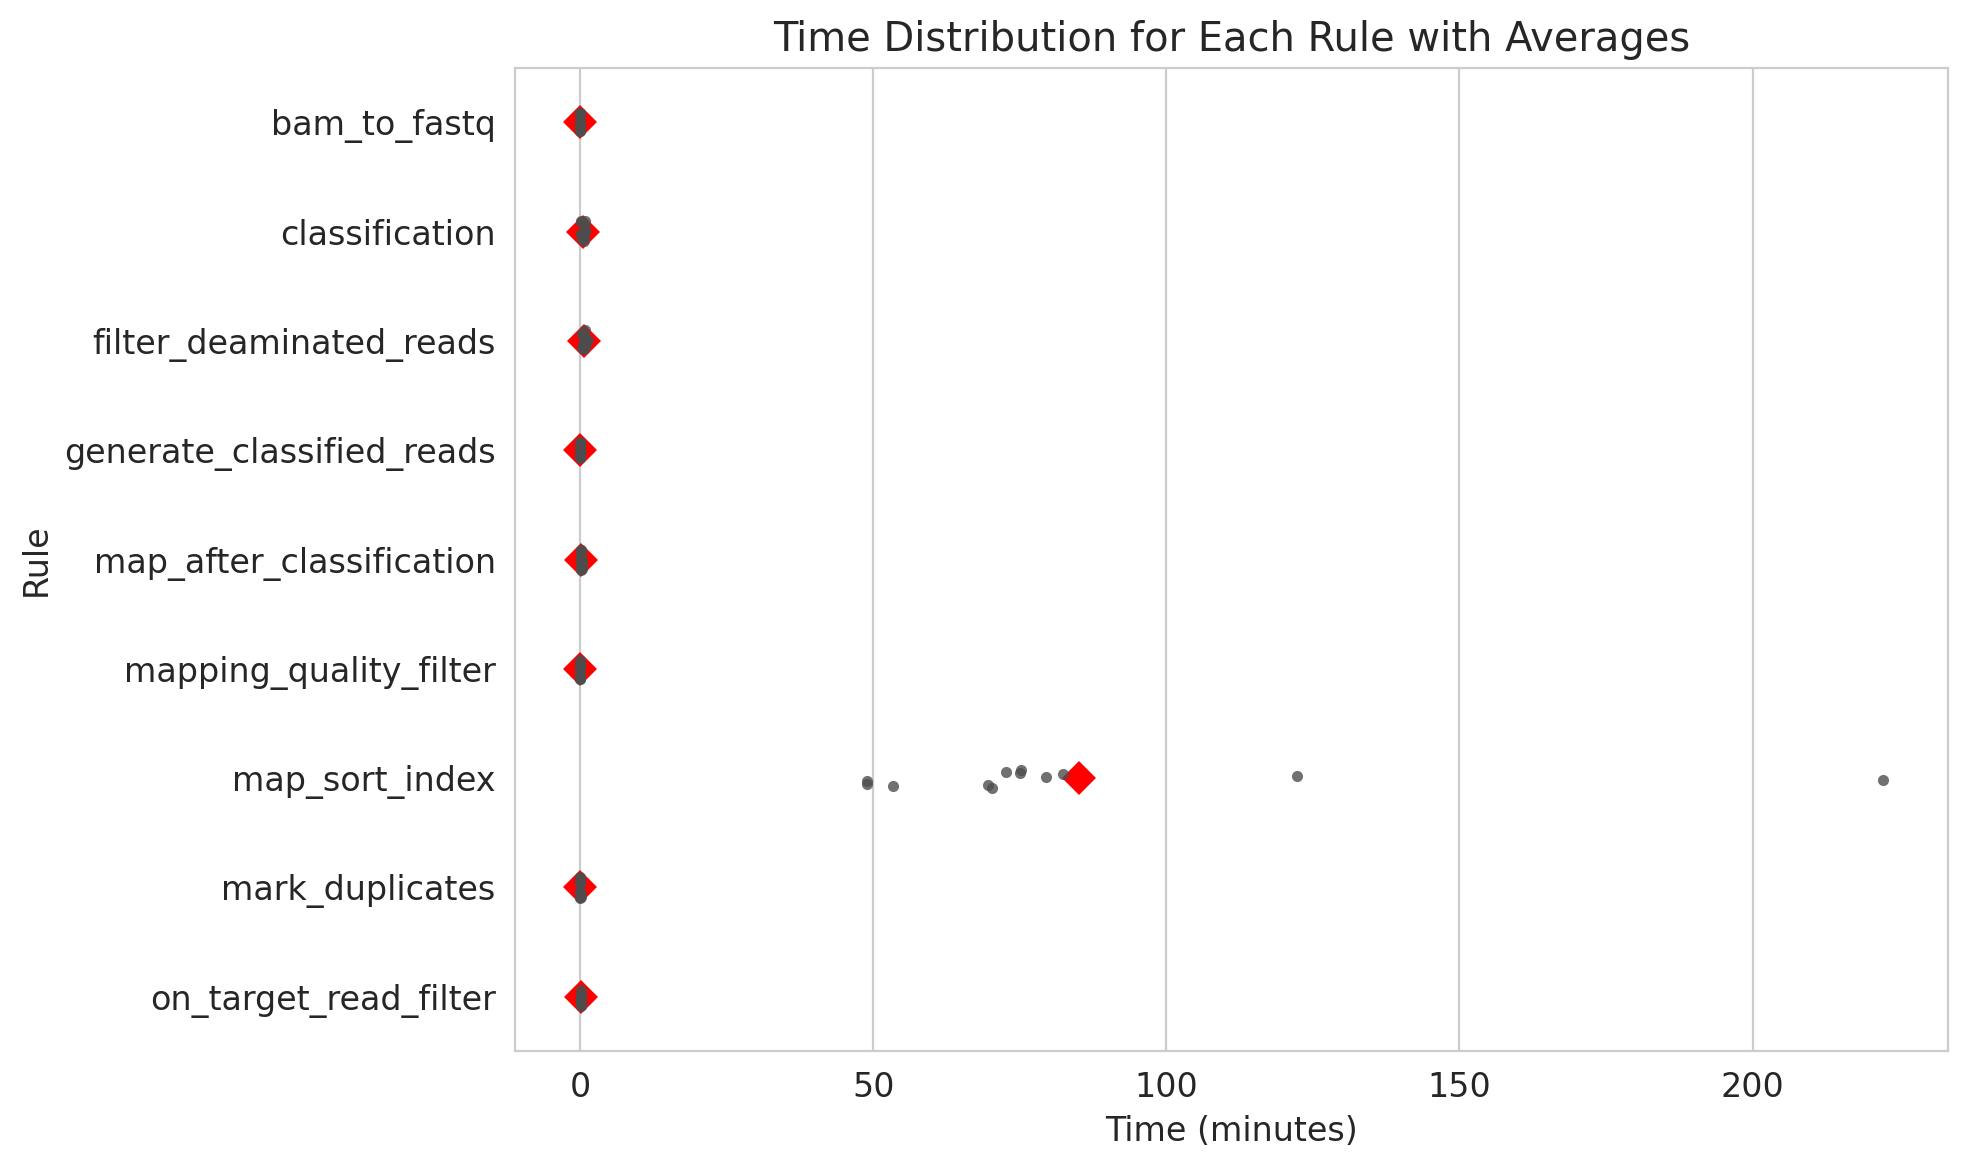

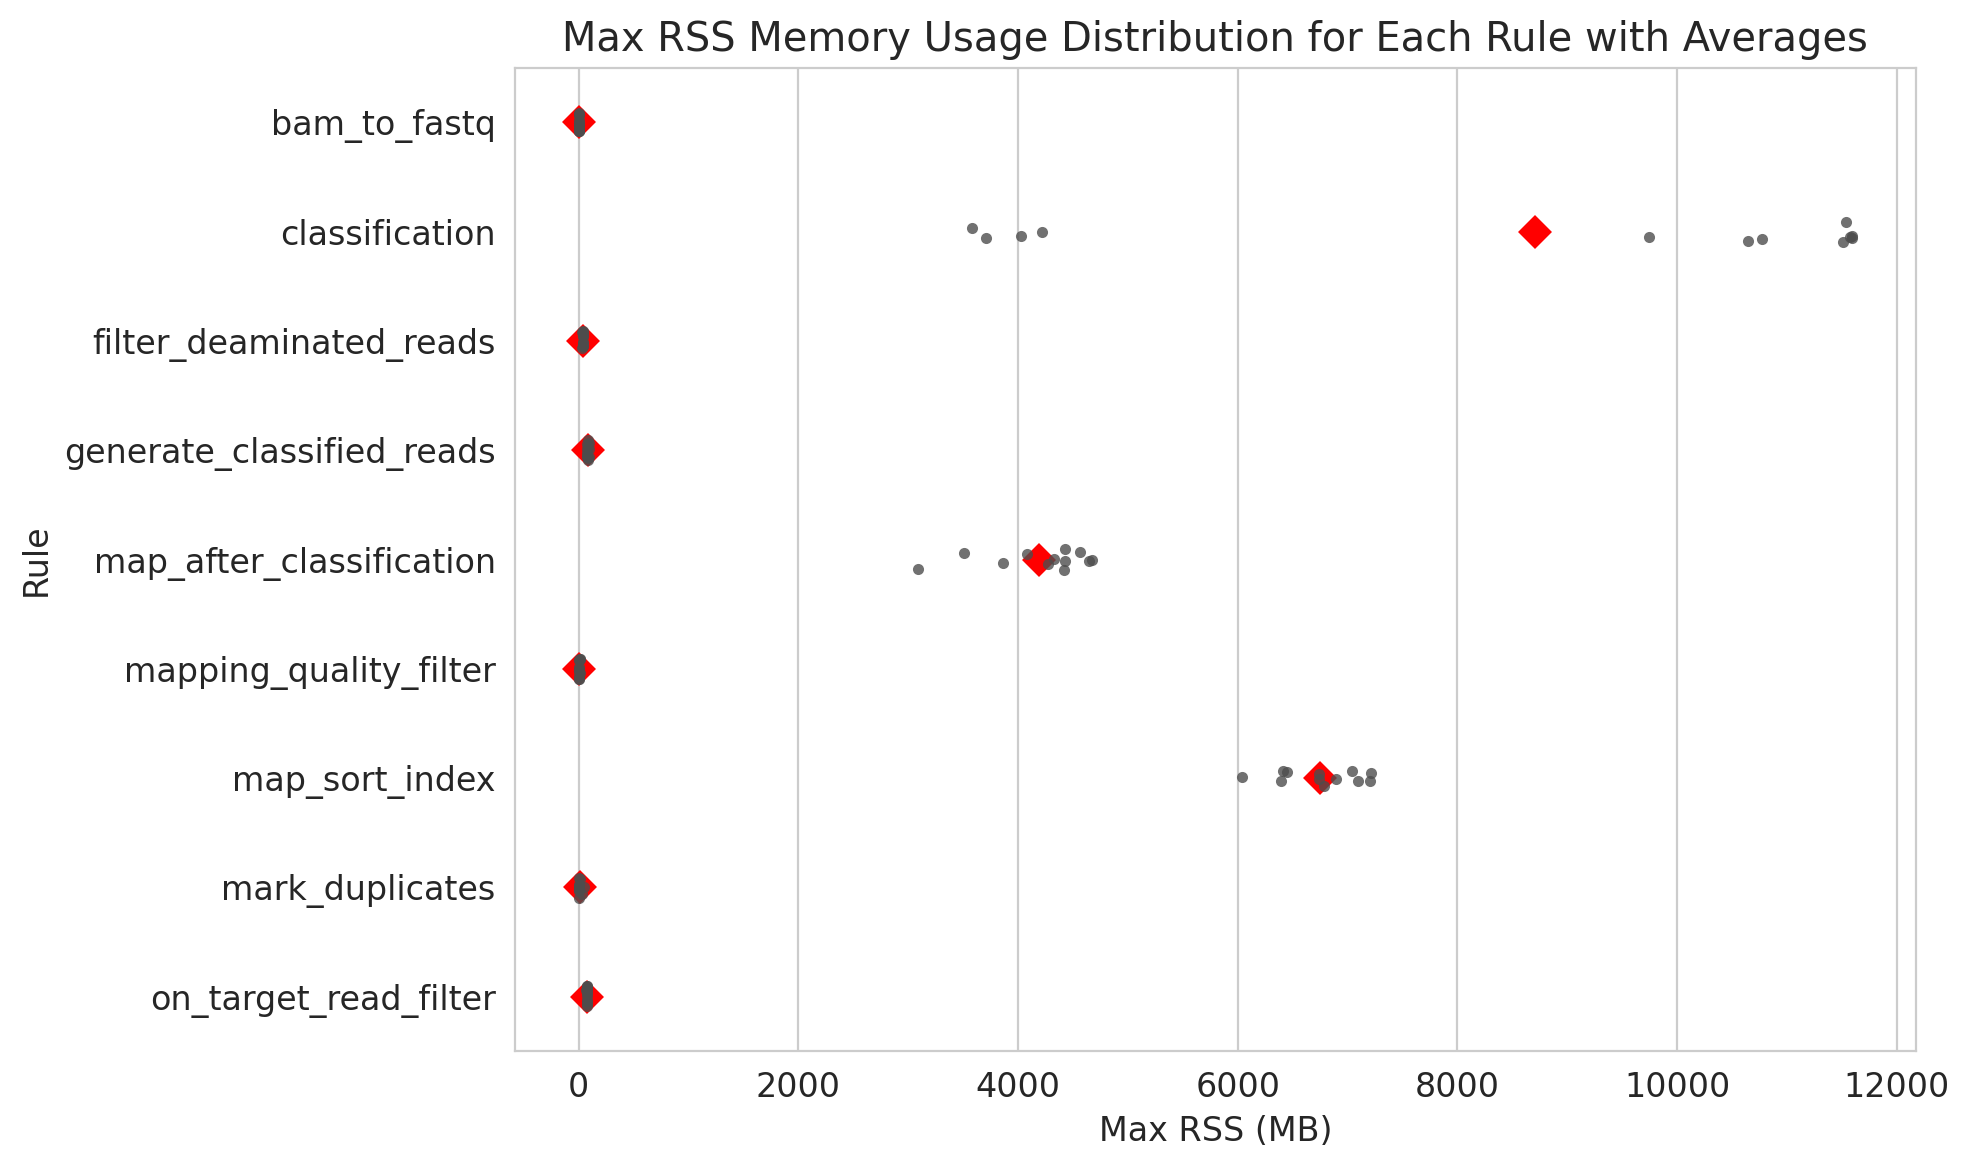

In [20]:
# Define the path to the benchmarks folder
base_path = '/global/home/users/jieruixu/jieruixu/sediment_dna/sedimix/pipeline/vernot_2021_figure_samples/benchmarks'

# List of rule folders
rule_folders = [
    'bam_to_fastq', 'classification', 'filter_deaminated_reads',
    'generate_classified_reads', 'map_after_classification', 
    'mapping_quality_filter', 'map_sort_index', 'mark_duplicates', 'on_target_read_filter'
]

# Call the function with the provided base path and rule folders
_ = analyze_benchmarks(base_path, rule_folders, True)

In [10]:
def calculate_average_reads(report_file):
    df_report = pd.read_csv(report_file, sep='\t')
    average_reads_million = np.mean(df_report['total_reads']) / 1_000_000
    print(f"Average number of input reads: {average_reads_million:.2f} million")

In [11]:
report_file = "/global/home/users/jieruixu/jieruixu/sediment_dna/sedimix/pipeline/vernot_2021_figure_samples/final_report/combined_final_report.tsv"
calculate_average_reads(report_file) 

Average number of input reads: 8.61 million


## Now analyze simulation with 95% bact 5% Neanderthal

In [34]:
def aggregate_data(base_paths, rule_folders, plot=False):
    total_times = []
    max_memories = []
    num_reads_values = []

    for base_path in base_paths:
        benchmarks_df = analyze_benchmarks(base_path, rule_folders, plot)
        if benchmarks_df.empty:
            continue

        # Aggregate total time and max memory usage
        total_time = benchmarks_df['minutes'].sum() if 'minutes' in benchmarks_df.columns else 0
        max_memory = benchmarks_df[['max_rss', 'max_vms', 'max_uss', 'max_pss']].max().max() if not benchmarks_df[['max_rss', 'max_vms', 'max_uss', 'max_pss']].empty else 0

        num_reads = base_path.split('/')[-3].split('_')[-1]

        total_times.append(total_time)
        max_memories.append(max_memory)
        num_reads_values.append(num_reads)

    return num_reads_values, total_times, max_memories

### Performance 

In [30]:
# Define all Simulation folders
num_reads = ['1M', '10M', '50M', '100M'] 
sim_folders = [f'SIM_Set5_{num_read}' for num_read in num_reads]

# Define the path to the benchmarks folder
base_paths = [f'/global/home/users/jieruixu/jieruixu/sediment_dna/sedimix/pipeline/{sim_folder}/benchmarks' for sim_folder in sim_folders]

# List of rule folders, fastq_to_bam rule's benchmark is called map_after_classification
# forgot to add final_report to the benchmark 
rule_folders = [
    'map_sort_index', 'on_target_read_filter', 'mapping_quality_filter', 'mark_duplicates', 
    'bam_to_fastq', 'classification', 'generate_classified_reads', 'map_after_classification', 
    'run_mapdamage_after_classification', 'filter_deaminated_reads'
]

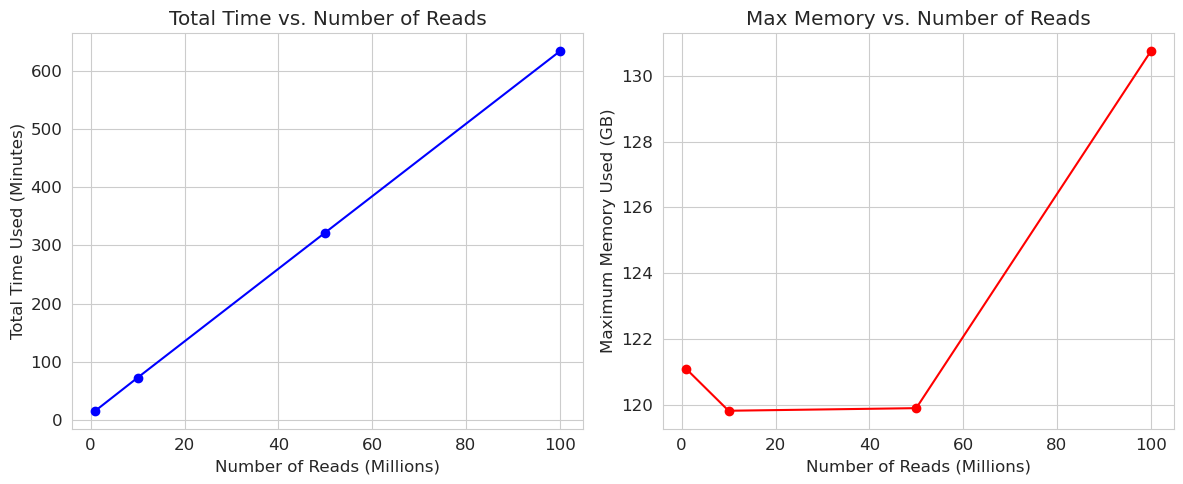

In [41]:
# Aggregate data without plotting
num_reads_values, total_times, max_memories = aggregate_data(base_paths, rule_folders, plot=False)

# Convert num_reads_values to numeric for plotting
num_reads_values_numeric = [int(nr.rstrip('M')) for nr in num_reads]

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Plot total time used to run the whole pipeline in the first subplot
axs[0].plot(num_reads_values_numeric, np.array(total_times), marker='o', linestyle='-', color='b')
axs[0].set_xlabel('Number of Reads (Millions)')
axs[0].set_ylabel('Total Time Used (Minutes)')
axs[0].set_title('Total Time vs. Number of Reads')

# Plot maximum memory used to run the whole pipeline in the second subplot
axs[1].plot(num_reads_values_numeric, np.array(max_memories) / 1024, marker='o', linestyle='-', color='r')
axs[1].set_xlabel('Number of Reads (Millions)')
axs[1].set_ylabel('Maximum Memory Used (GB)')
axs[1].set_title('Max Memory vs. Number of Reads')

plt.tight_layout()
plt.show()

### Accuracy 

In [48]:
def calculate_accuracy(file_path):
    total_lines = 0
    matching_lines = 0
    
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('@'):
                total_lines += 1
                if line.startswith('@22'):
                    matching_lines += 1
                    
    accuracy = matching_lines / total_lines if total_lines > 0 else 0
    return accuracy

def bootstrap_accuracy(file_path, n_bootstraps=1000):
    accuracies = []
    
    with open(file_path, 'r') as file:
        lines = [line for line in file if line.startswith('@')]
        
    total_lines = len(lines)
    n_boostraps = total_lines
    for _ in range(n_bootstraps):
        sampled_lines = np.random.choice(lines, size=total_lines, replace=True)
        matching_lines = sum(1 for line in sampled_lines if line.startswith('@22'))
        accuracy = matching_lines / total_lines if total_lines > 0 else 0
        accuracies.append(accuracy)
    
    return np.percentile(accuracies, [2.5, 97.5]), np.mean(accuracies)

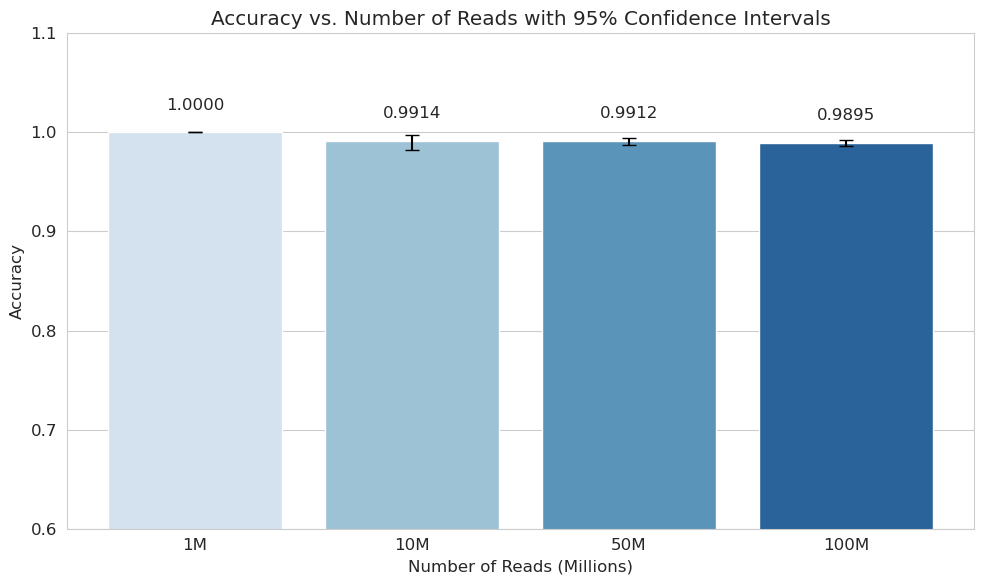

In [56]:
# Define all Simulation folders
num_reads = ['1M', '10M', '50M', '100M'] 

# Define the path to the final_reads folder
base_paths = [f'/global/home/users/jieruixu/jieruixu/sediment_dna/sedimix/pipeline/SIM_Set5_{num_read}/final_reads/simulation_s_trimmed_{num_read}_classified_homo_sapiens.fq' for num_read in num_reads]

accuracies = []
ci_lower = []
ci_upper = []

for file_path in base_paths:
    if os.path.exists(file_path):
        ci, mean_accuracy = bootstrap_accuracy(file_path)
        accuracies.append(mean_accuracy)
        ci_lower.append(ci[0])
        ci_upper.append(ci[1])
    else:
        accuracies.append(0)
        ci_lower.append(0)
        ci_upper.append(0)

# Plot accuracy
plt.figure(figsize=(10, 6), dpi=100)
sns.barplot(x=num_reads, y=accuracies, errorbar=None, palette='Blues', hue=num_reads, dodge=False, legend=False)
plt.errorbar(num_reads, accuracies, yerr=[np.array(accuracies) - np.array(ci_lower), np.array(ci_upper) - np.array(accuracies)], fmt='none', c='black', capsize=5)

# Annotate mean accuracies on top of each bar
for i, (x, y) in enumerate(zip(num_reads, accuracies)):
    plt.text(x, y + 0.02, f'{y:.4f}', ha='center', va='bottom')
    
plt.xlabel('Number of Reads (Millions)')
plt.ylabel('Accuracy')
plt.ylim(0.6, 1.1) 
plt.title('Accuracy vs. Number of Reads with 95% Confidence Intervals')
plt.tight_layout()
plt.show()

## Gelabert et al. 2021

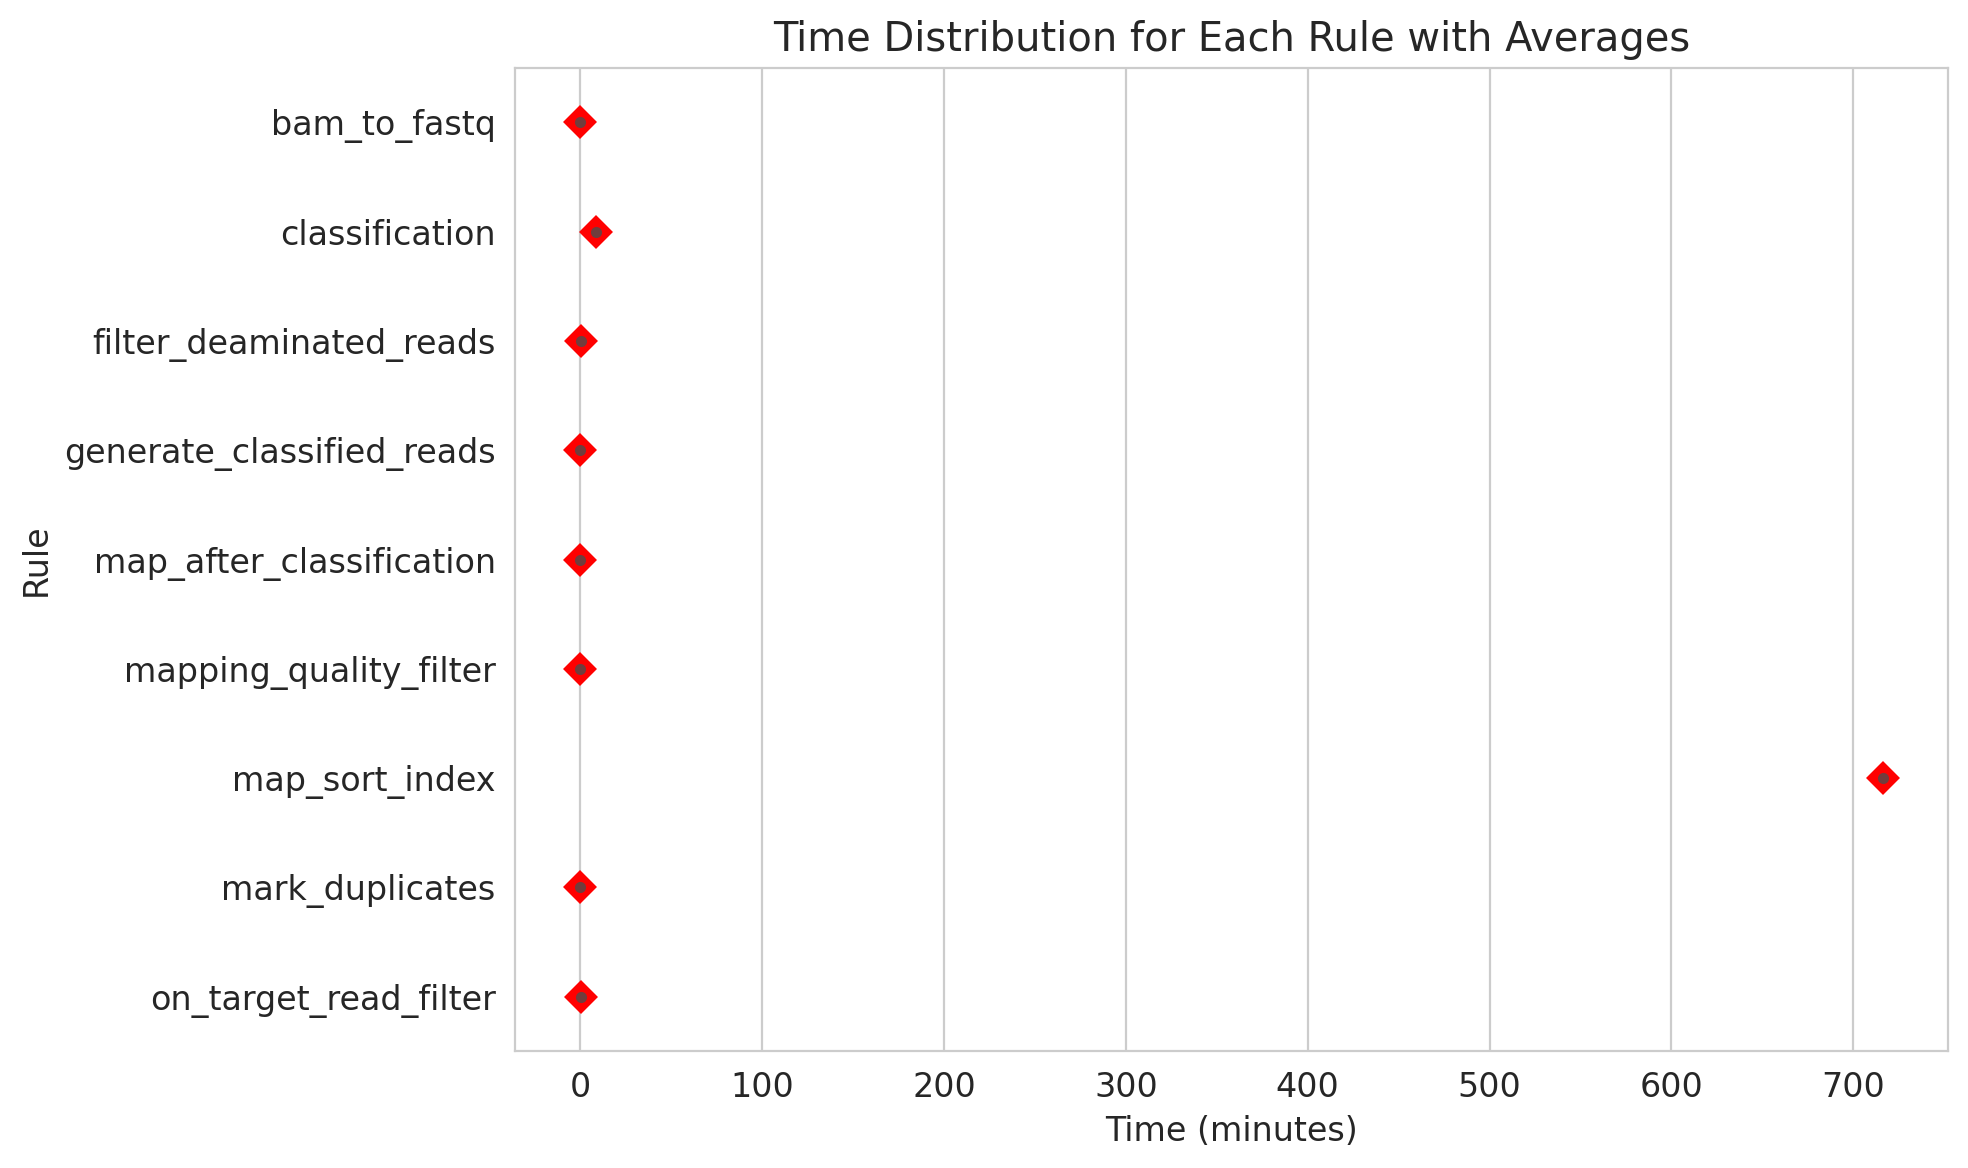

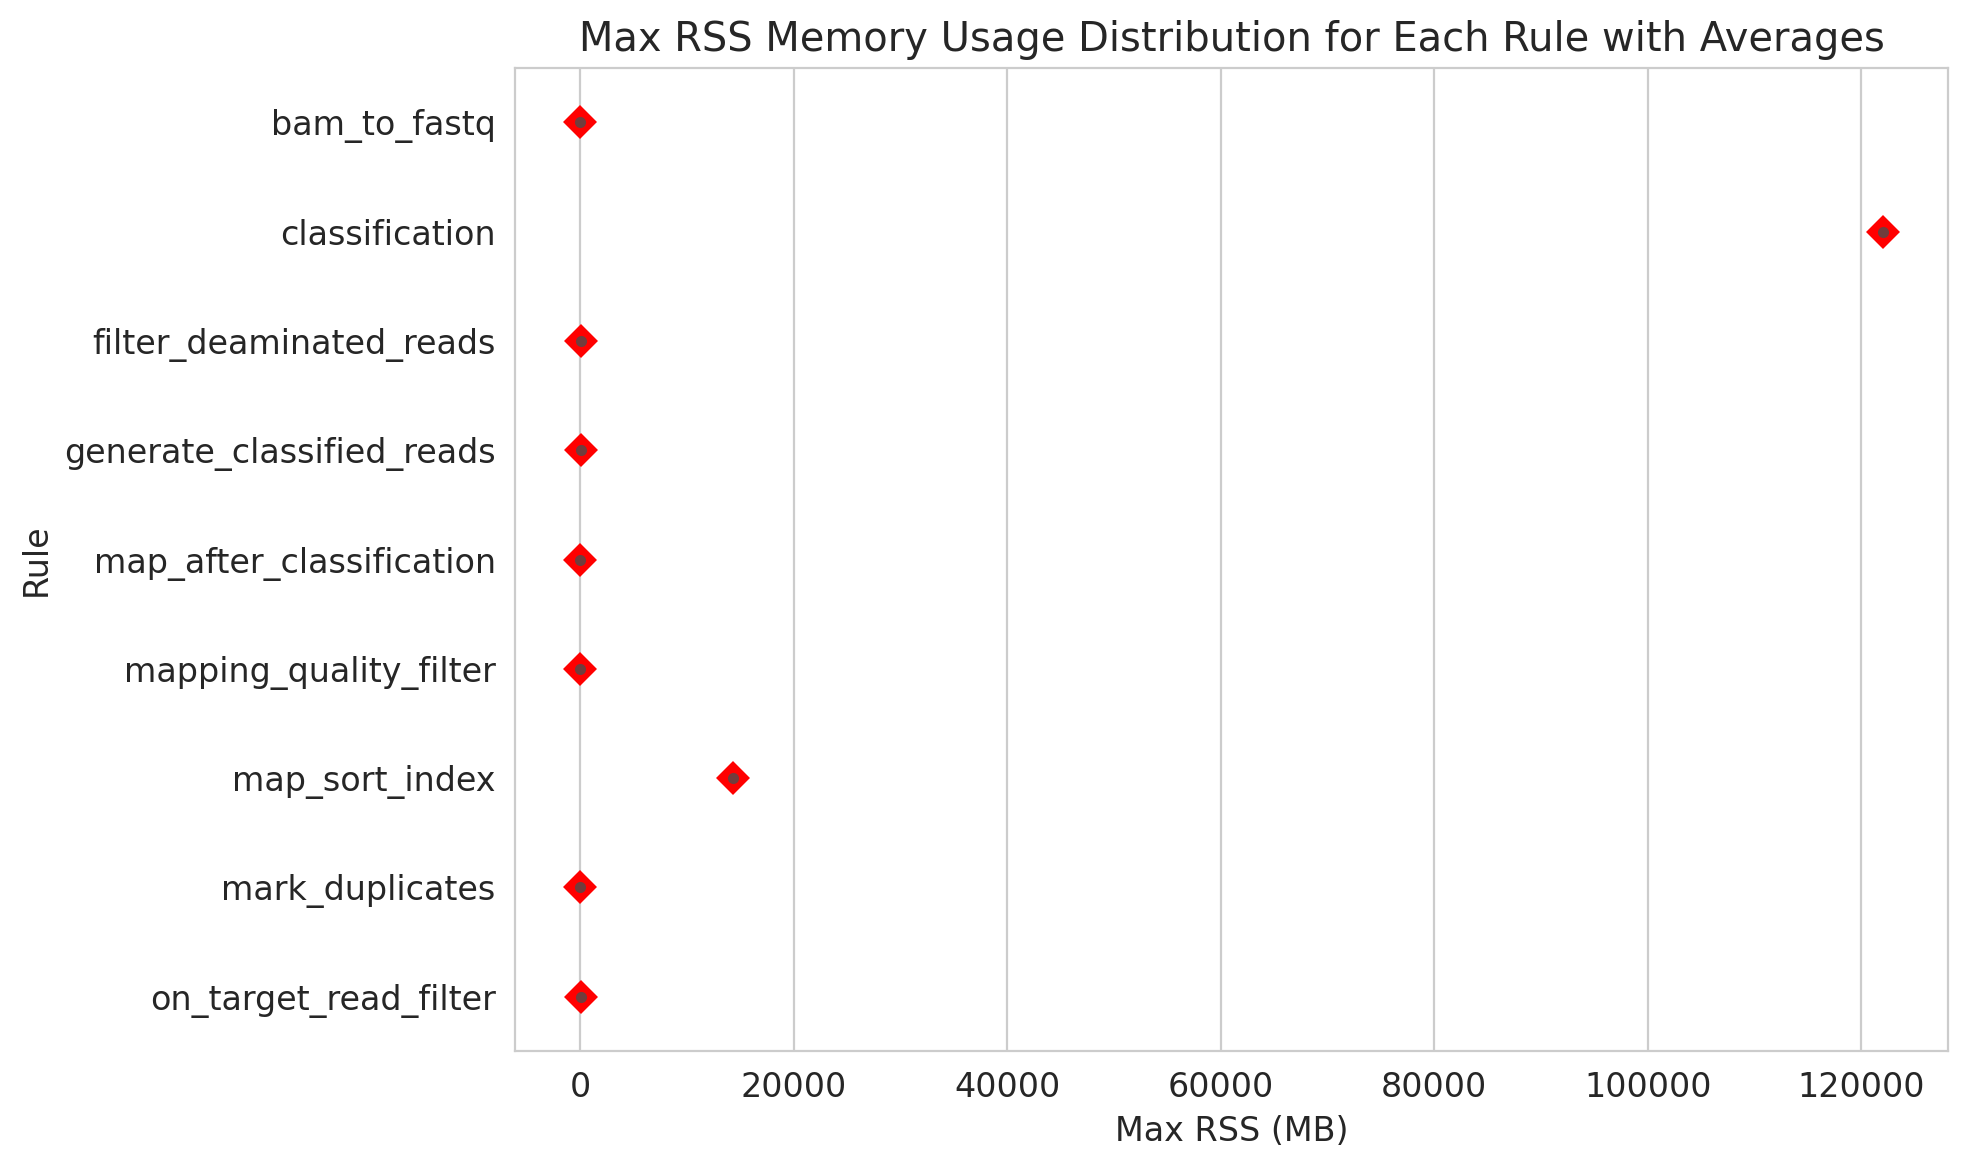

In [57]:
# Define the path to the benchmarks folder
base_path = '/global/home/users/jieruixu/jieruixu/sediment_dna/sedimix/pipeline/gelabert_2021_without_mask/benchmarks'

# List of rule folders
rule_folders = [
    'bam_to_fastq', 'classification', 'filter_deaminated_reads',
    'generate_classified_reads', 'map_after_classification', 
    'mapping_quality_filter', 'map_sort_index', 'mark_duplicates', 'on_target_read_filter'
]

# Call the function with the provided base path and rule folders
_ = analyze_benchmarks(base_path, rule_folders, True)

In [43]:
# # Call the function with the provided base path and rule folders
# for base_path in base_paths: 
#     analyze_benchmarks(base_path, rule_folders)

In [22]:
# Generate the dataframe with the required columns
average_minutes = benchmarks_df.groupby('rule')['minutes'].mean().reset_index()
total_average_minutes = average_minutes['minutes'].sum()
average_minutes['percentage_of_time'] = (average_minutes['minutes'] / total_average_minutes) * 100

# Sort the dataframe by the percentage of time
average_minutes = average_minutes.sort_values(by='percentage_of_time', ascending=False)
average_minutes = average_minutes.rename(columns={'minutes': 'average_minutes_executed'})

# # Save the dataframe to a TSV file
# average_minutes.to_csv('/mnt/data/rule_execution_times.tsv', sep='\t', index=False) 

In [23]:
average_minutes

,rule,average_minutes_executed,percentage_of_time
5,map_sort_index,85.013889,98.368823
2,filter_deaminated_reads,0.687500,0.795500
1,classification,0.486111,0.562475
4,map_after_classification,0.133333,0.154279
8,on_target_read_filter,0.079167,0.091603
3,generate_classified_reads,0.016667,0.019285
7,mark_duplicates,0.005556,0.006428
6,mapping_quality_filter,0.001389,0.001607
0,bam_to_fastq,0.000000,0.000000


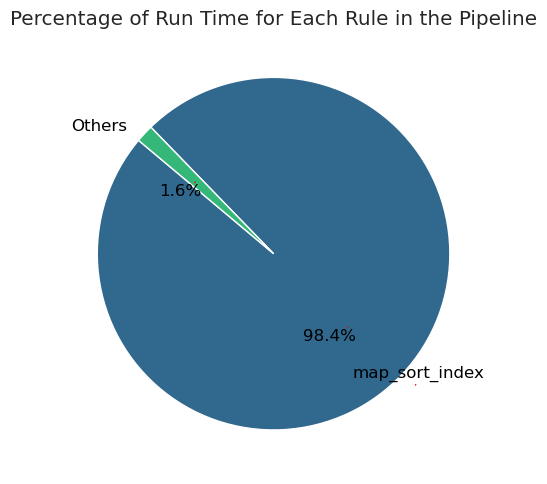

In [39]:
# Create a copy for pie chart generation
pie_chart_data = average_minutes.copy()

# Group rules causing less than 1% of time into "Others"
threshold = 1.0
others = pie_chart_data[pie_chart_data['percentage_of_time'] < threshold].copy()
others_sum = others['percentage_of_time'].sum()

# Filter out the "Others" from the main dataframe for the pie chart
pie_chart_data = pie_chart_data[pie_chart_data['percentage_of_time'] >= threshold]

# Append "Others" to the dataframe for the pie chart
if not others.empty:
    others_row = pd.DataFrame({'rule': ['Others'], 'average_minutes_executed': [others['average_minutes_executed'].sum()], 'percentage_of_time': [others_sum]})
    pie_chart_data = pd.concat([pie_chart_data, others_row])

# Generate the pie chart with adjusted label positioning to avoid overlap
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
wedges, texts, autotexts = ax.pie(pie_chart_data['percentage_of_time'], labels=pie_chart_data['rule'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(pie_chart_data)), startangle=140)

# Adjust the text properties for better readability
for text in texts + autotexts:
    text.set_fontsize(12)
    text.set_color('black')

# Collect all texts for adjust_text
all_texts = texts + autotexts

# Adjust the label positions to avoid overlap
adjust_text(all_texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

# Set the title
ax.set_title('Percentage of Run Time for Each Rule in the Pipeline')

# Make it look good for scientific publication
plt.tight_layout()
plt.show()

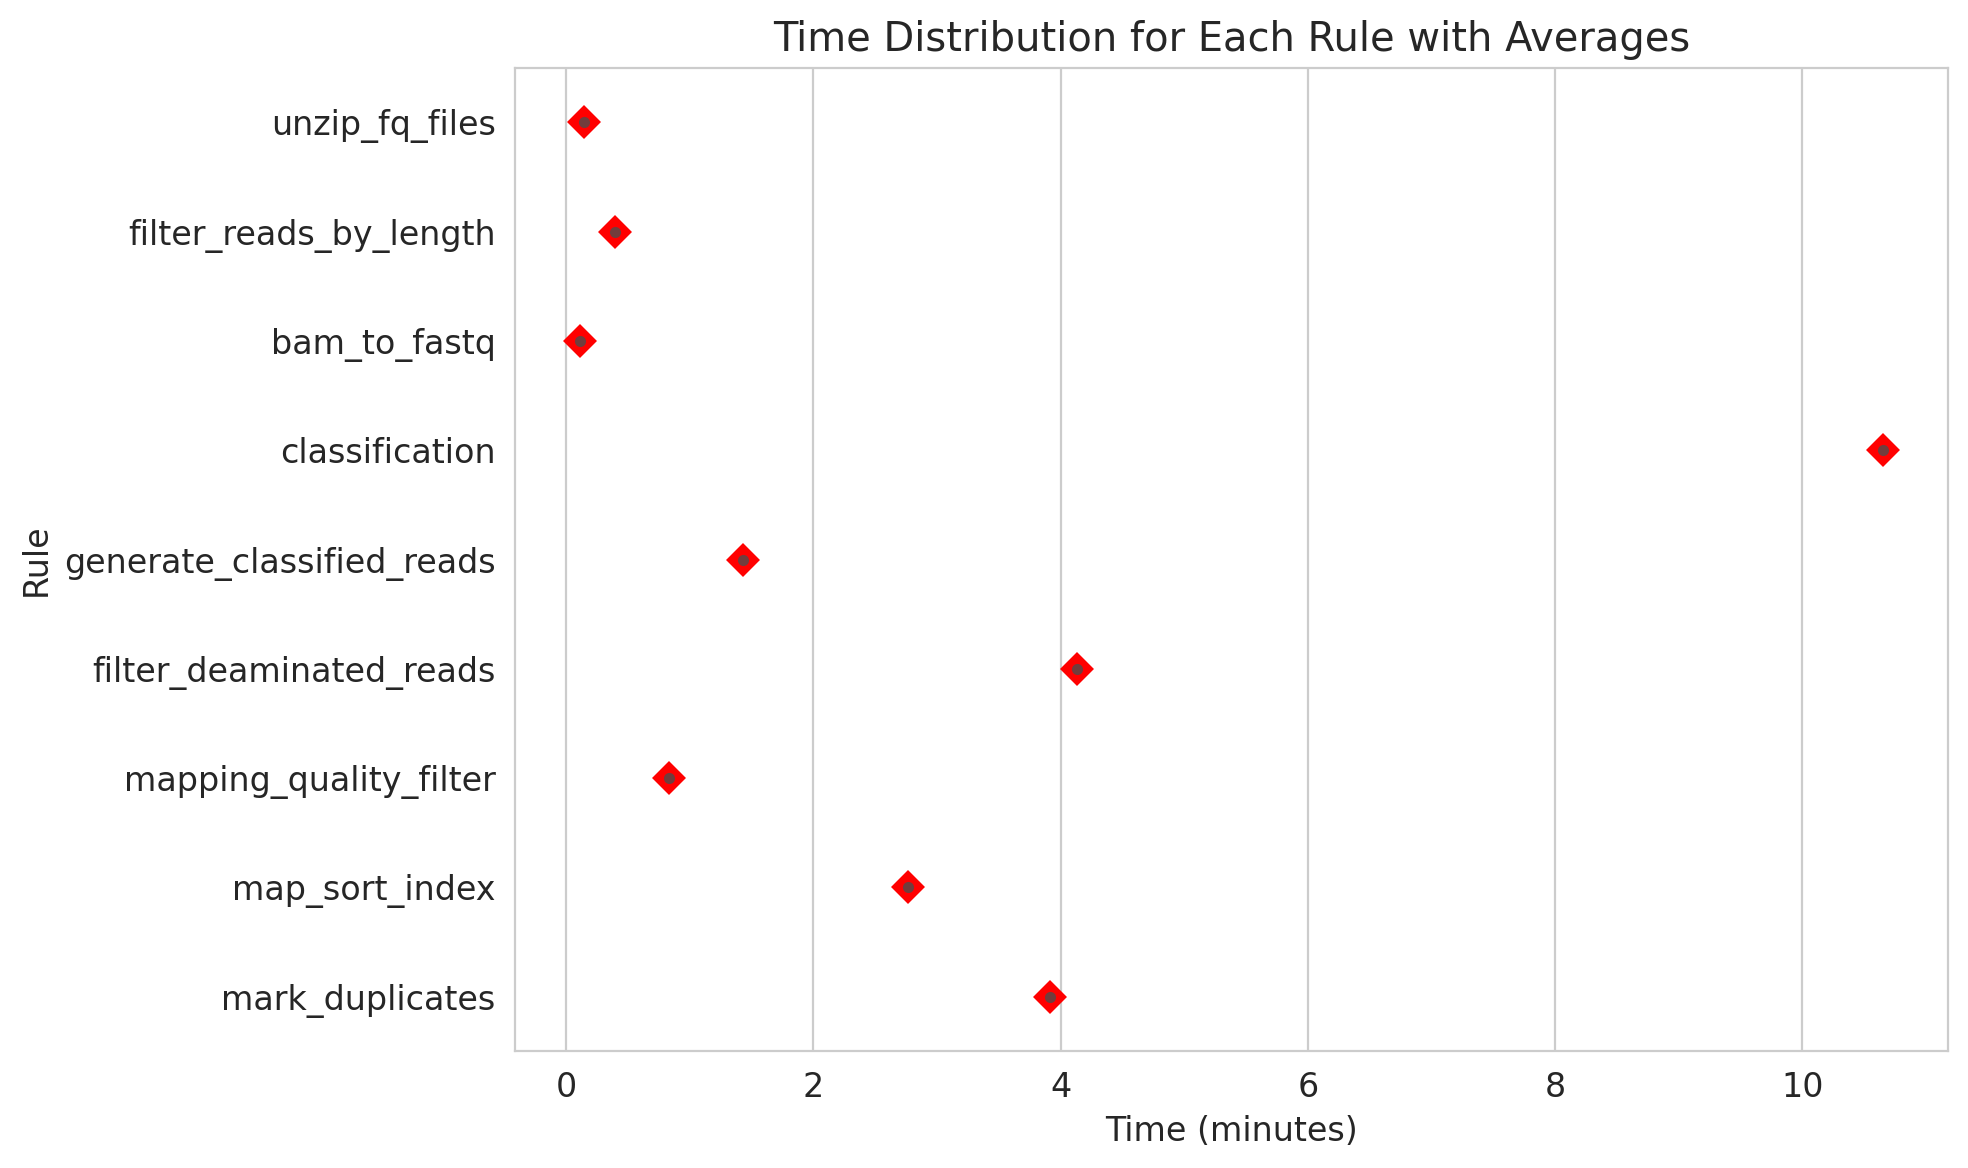

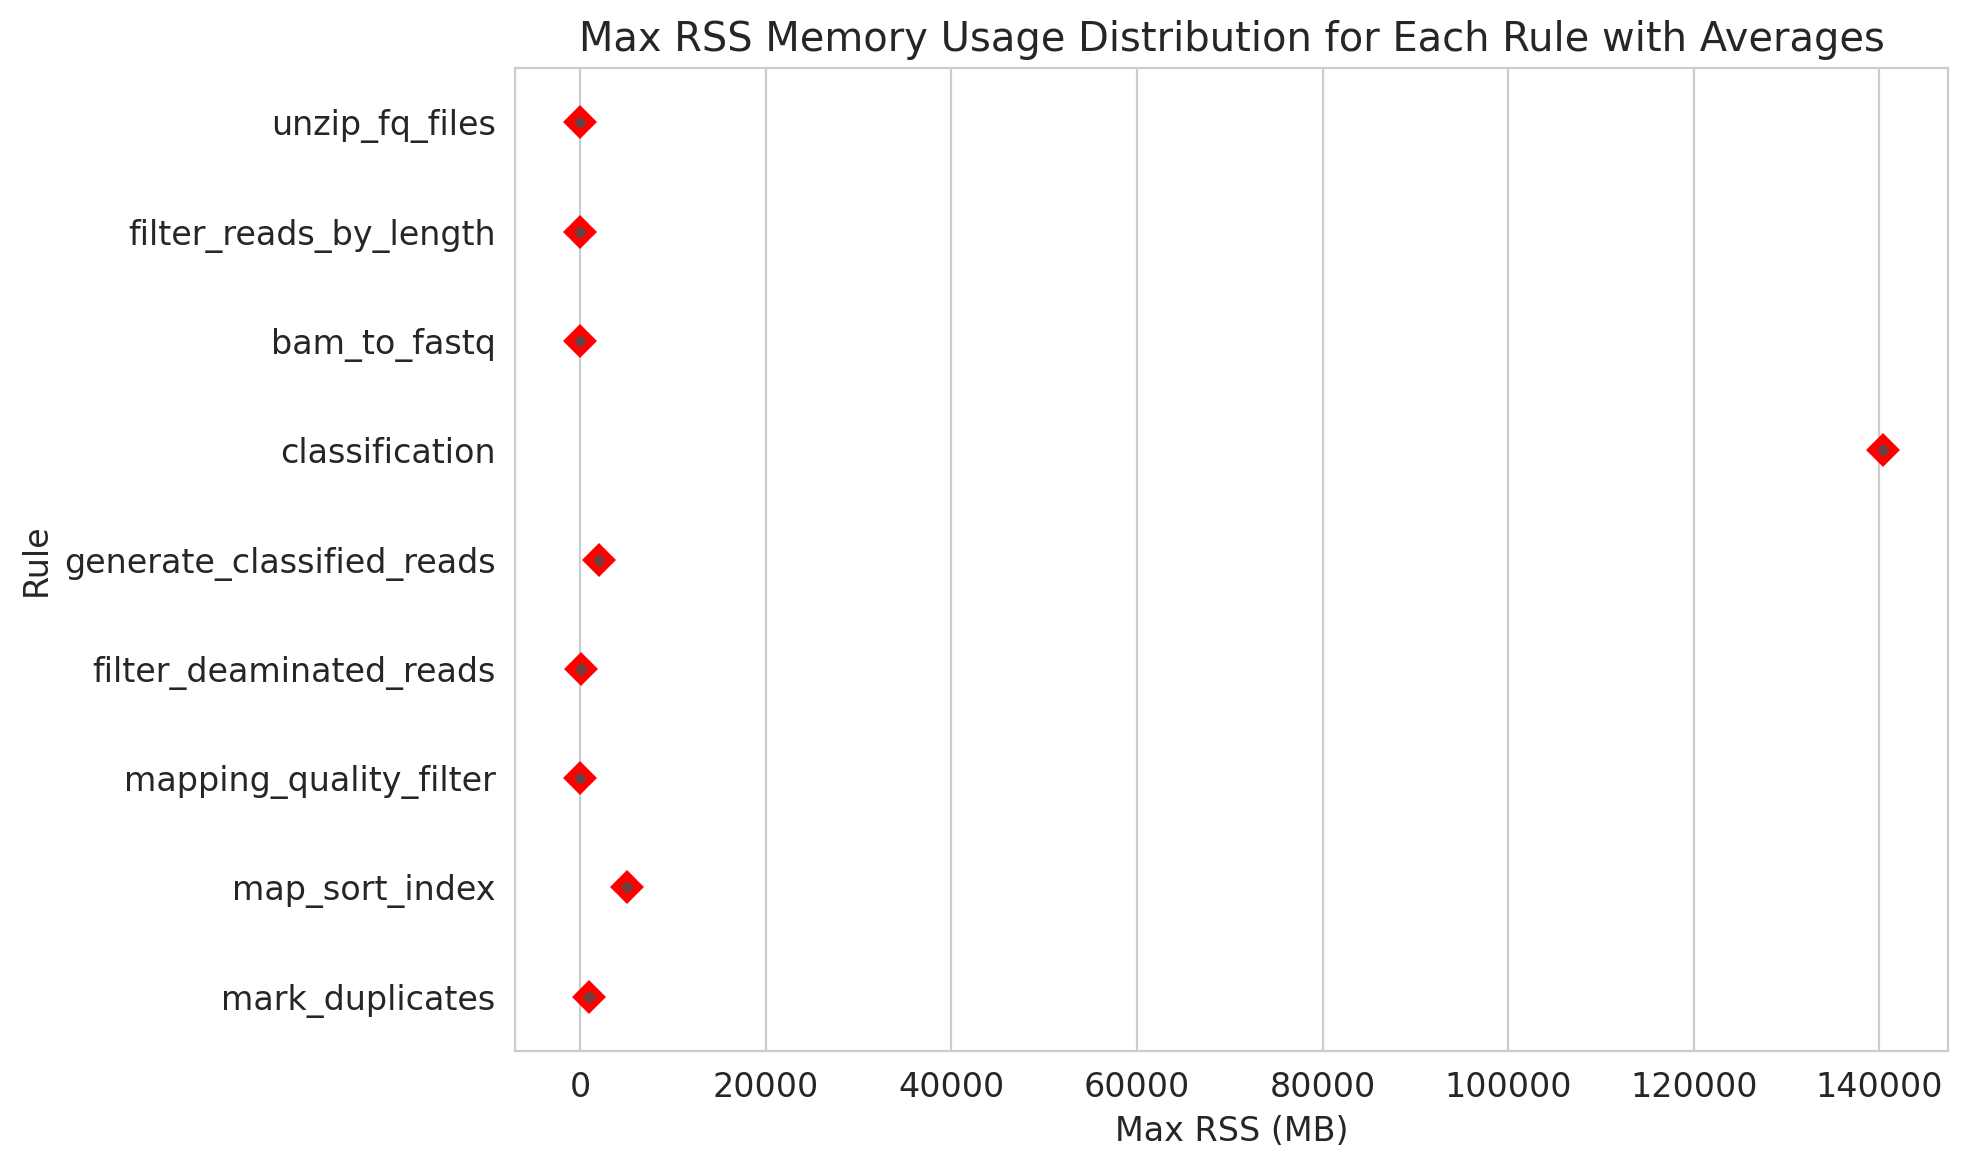

In [6]:
# Define the path to the benchmarks folder
base_path = '/global/home/users/jieruixu/jieruixu/sediment_dna/sedimix/final_pipeline/SIM_set1_centrifuge/benchmarks'

# List of rule folders
rule_folders = [
    'unzip_fq_files', 'filter_reads_by_length', 'bam_to_fastq', 
    'classification', 'generate_classified_reads', 'filter_deaminated_reads',
    'mapping_quality_filter', 'map_sort_index', 'mark_duplicates', 'on_target_read_filter'
]

# Call the function with the provided base path and rule folders
_ = analyze_benchmarks(base_path, rule_folders, True)

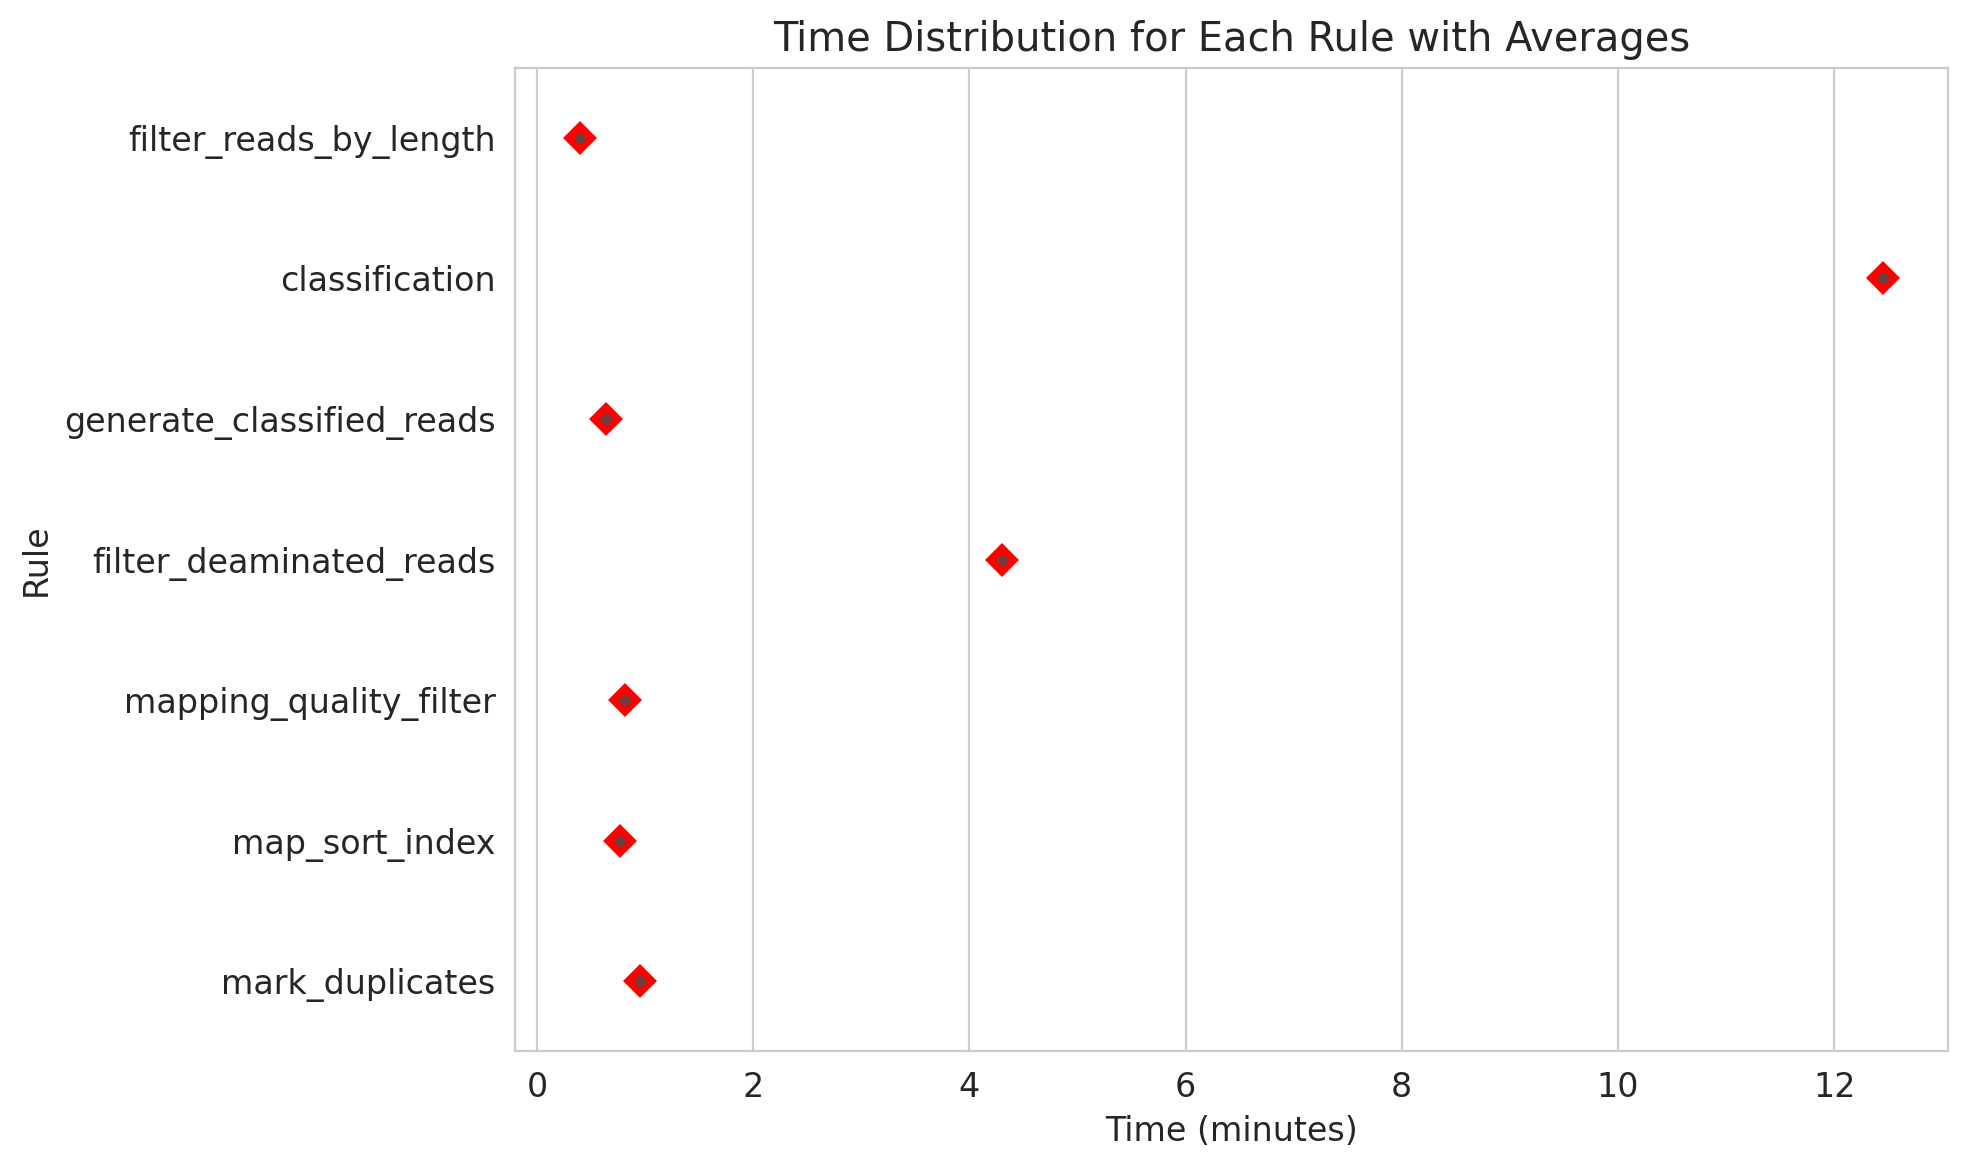

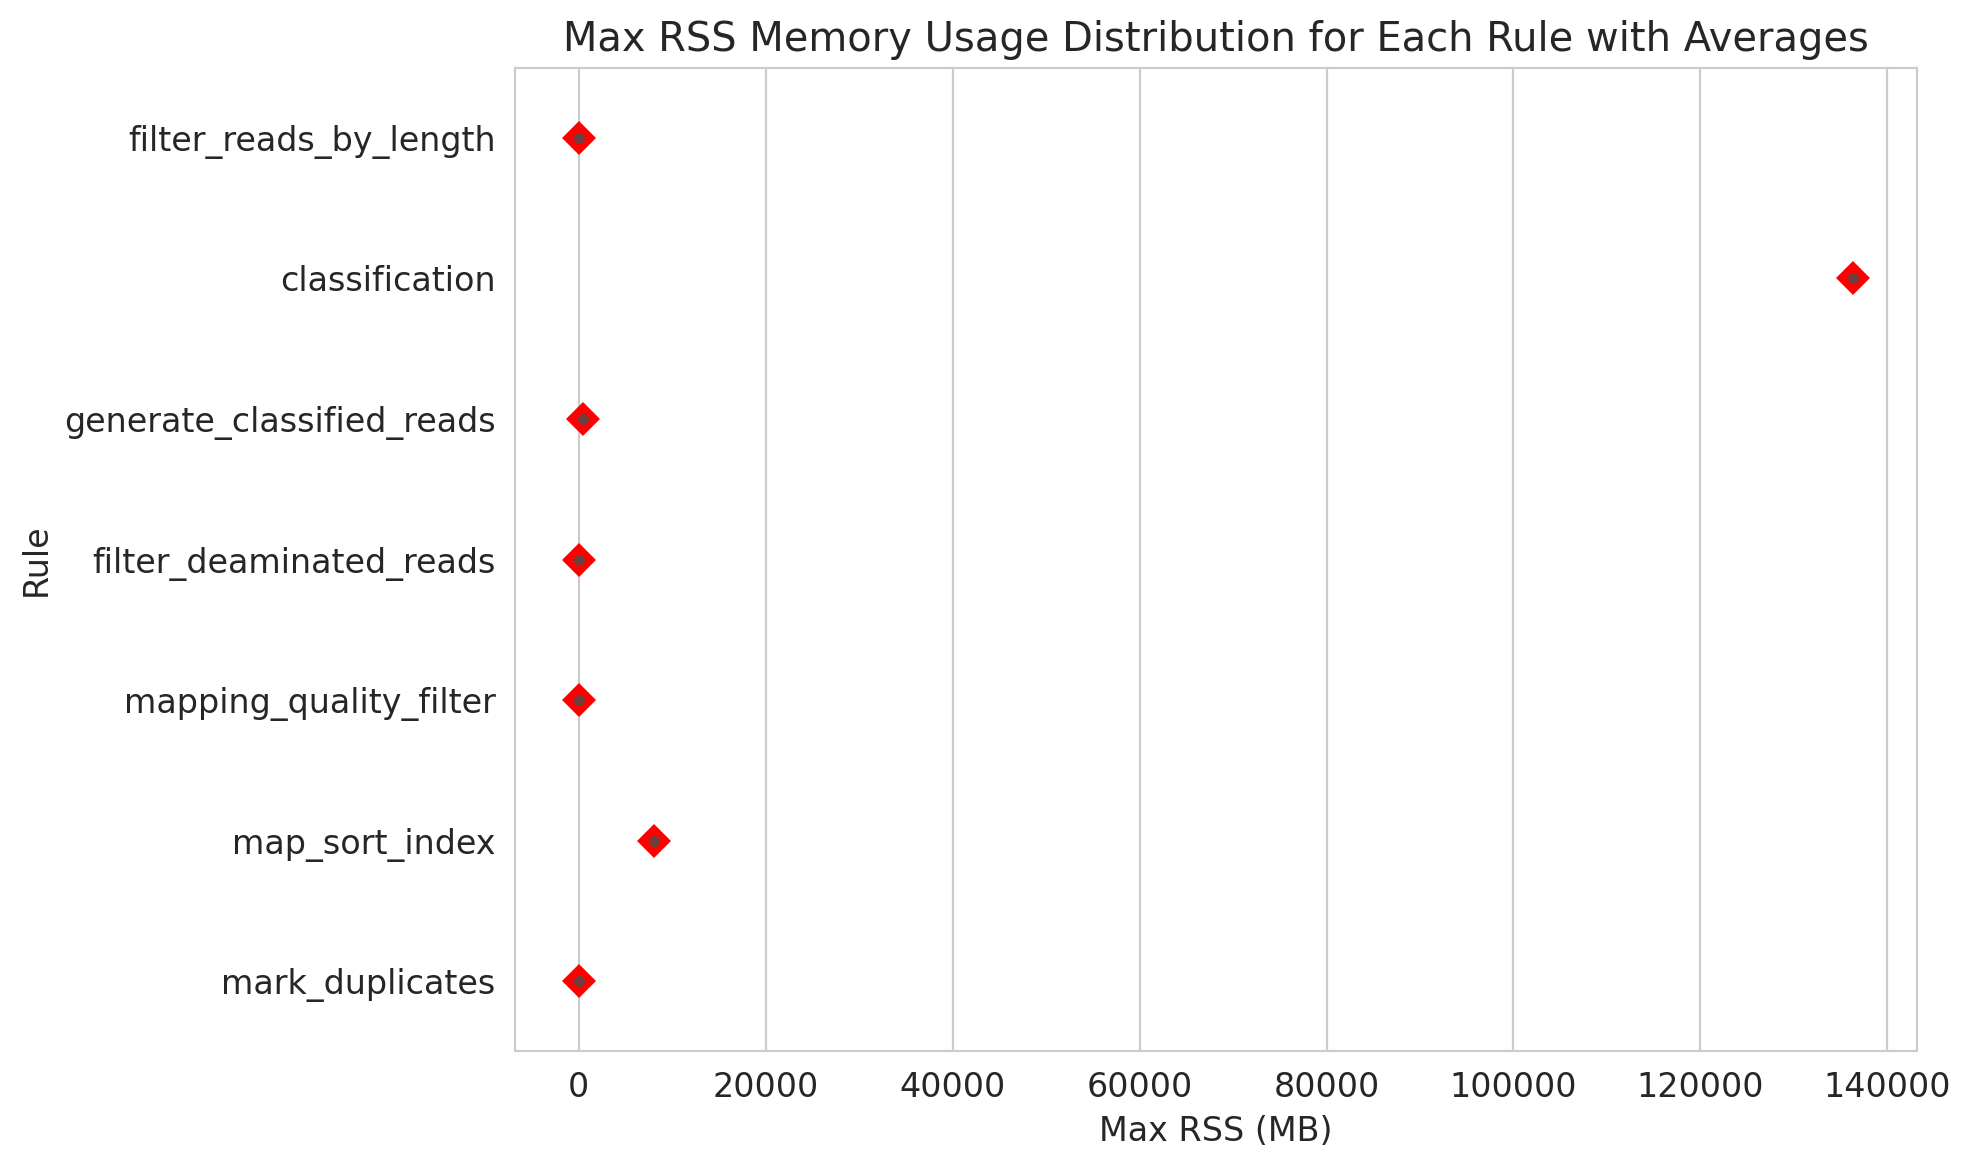

In [7]:
# Define the path to the benchmarks folder
base_path = '/global/home/users/jieruixu/jieruixu/sediment_dna/sedimix/final_pipeline/SIM_set1_classification_first/benchmarks'

# List of rule folders
rule_folders = [
    'unzip_fq_files', 'filter_reads_by_length', 'bam_to_fastq', 
    'classification', 'generate_classified_reads', 'filter_deaminated_reads',
    'mapping_quality_filter', 'map_sort_index', 'mark_duplicates', 'on_target_read_filter'
]

# Call the function with the provided base path and rule folders
_ = analyze_benchmarks(base_path, rule_folders, True)